In [7]:
from percolation import TemporalPercolation
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools

In [8]:
def preprocess(dataset_name: str):
        
        u_list, i_list, ts_list, label_list = [], [], [], []
        feat_l = []
        idx_list = []

        try:
            with open(dataset_name, 'r') as f:
                # Detect and skip the header
                first_line = f.readline().strip()
                if not first_line.replace(',', '').isdigit():
                    print("Detected header, skipping it...")
                else:
                    # go back if no header
                    f.seek(0)

                previous_time = -1
                for idx, line in enumerate(f):
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue

                    e = line.split(',')
                    if len(e) < 4:
                        print(f"Skipping malformed line {idx}: {line}")
                        continue

                    try:
                        u = int(e[0])  
                        i = int(e[1])  
                        ts = float(e[2])  
                        label = float(e[3])  

                        # rest
                        feat = np.array([float(x) for x in e[4:]])

                        if ts < previous_time:
                            raise ValueError(f"Timestamps are not sorted at line {idx}: {line}")
                        previous_time = ts

                        u_list.append(u)
                        i_list.append(i)
                        ts_list.append(ts)
                        label_list.append(label)
                        idx_list.append(idx)
                        feat_l.append(feat)
                    except ValueError as ve:
                        print(f"Skipping line {idx} due to error: {ve}")
                        continue

        except FileNotFoundError:
            raise FileNotFoundError(f"The file '{dataset_name}' does not exist or cannot be opened.")
        except Exception as e:
            raise RuntimeError(f"An error occurred while processing the file: {e}")

        if not u_list or not i_list or not ts_list:
            raise ValueError("No valid data found in the file.")
        
        df = pd.DataFrame({
            'u': u_list,
            'i': i_list,
            'ts': ts_list,
            'label': label_list,
            'idx': idx_list
        })


        feat_array = np.array(feat_l)
        print("=== Preprocessing Complete ===")
        print("Dataset Preview:")
        print(df.head())
        print("Feature Array Shape:", feat_array.shape)

        return df, feat_array

In [ ]:
file_path = "wikipedia.csv"
bipartite = True

df, feat_array  = preprocess(file_path)

print("Dataset Preview:")
print(df.head())

print("Timestamps Range:", df['ts'].min(), "-", df['ts'].max()) 
df['normalized_ts'] = (df['ts'] - df['ts'].min()) / 3600 # Normalize and converting to hours

tedges = list(df[['u', 'i', 'normalized_ts']].itertuples(index=False, name=None))

temporal_graph = pp.TemporalGraph.from_edge_list(tedges)
total_events = len(tedges)

bipartite_percolation = TemporalPercolation(temporal_graph, total_events)

min_t = df['normalized_ts'].min()  
max_t = 1678373 / 3600  # Max time in hours

# First I search broadly to find the critical threshold
# After that I can narrow down the search range
delta_t_values = np.linspace(min_t, max_t, num=50)

# Refined search range after identifying a critical region
refined_delta_t_values = np.linspace((20000/3600), (548040/3600), num=30)

# This was the final search, so I combine both sets of delta_t values and remove duplicates
combined_delta_t_values = np.unique(np.concatenate((delta_t_values, refined_delta_t_values)))

# it will take 3 hours to run, so I saved the results in a json file
# analysis_results, percolation_metrics = bipartite_percolation.percolation_analysis(combined_delta_t_values)

# with open("wikipedia_results/analysis_results.json", "w") as file:
#     json.dump(analysis_results, file, indent=4)

# Load results from the JSON file
with open("wikipedia_results/analysis_results_hours2.json", "r") as file:
    analysis_results = json.load(file)


Detected header, skipping it...
=== Preprocessing Complete ===
Dataset Preview:
   u  i     ts  label  idx
0  0  0    0.0    0.0    0
1  1  1   36.0    0.0    1
2  1  1   77.0    0.0    2
3  2  2  131.0    0.0    3
4  1  1  150.0    0.0    4
Feature Array Shape: (157474, 172)
Dataset Preview:
   u  i     ts  label  idx
0  0  0    0.0    0.0    0
1  1  1   36.0    0.0    1
2  1  1   77.0    0.0    2
3  2  2  131.0    0.0    3
4  1  1  150.0    0.0    4
Timestamps Range: 0.0 - 2678373.0


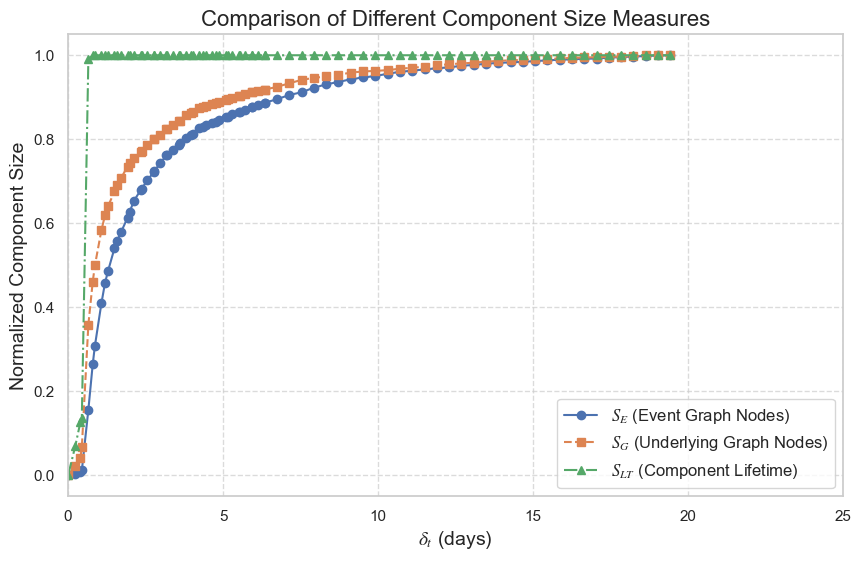


Correlation between measures:
           S_E       S_G      S_LT
S_E   1.000000  0.984595  0.704321
S_G   0.984595  1.000000  0.816388
S_LT  0.704321  0.816388  1.000000


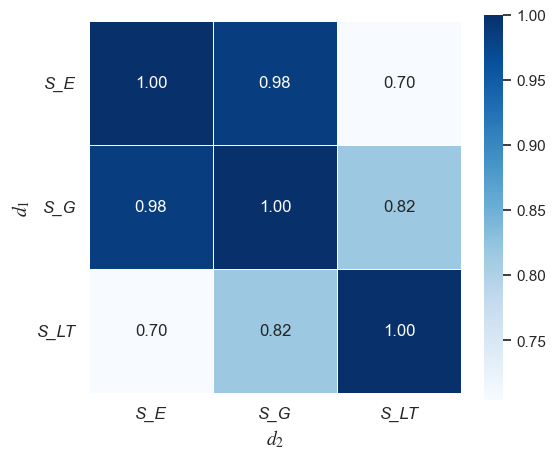

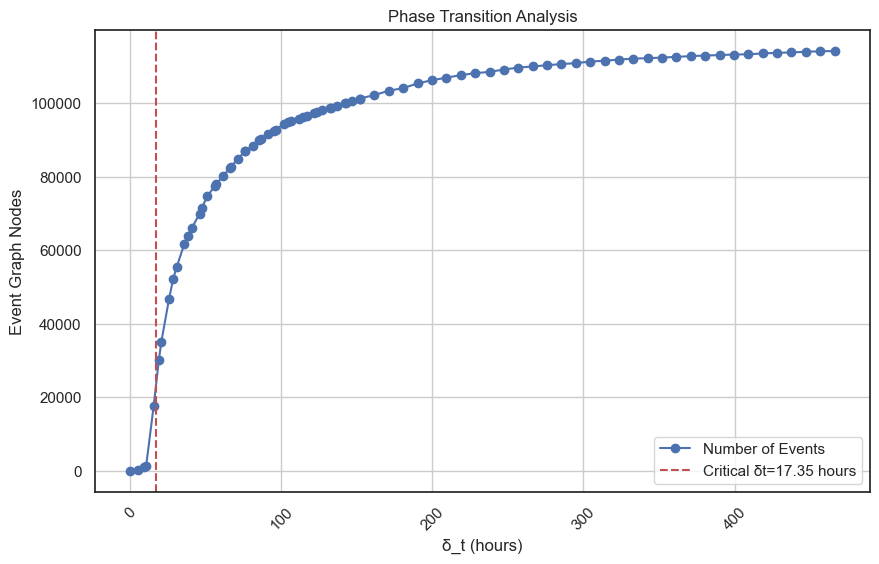

In [10]:
delta_t_values = np.array([float(k) for k in analysis_results.keys()])

bipartite_percolation.compare_component_measures(analysis_results)
bipartite_percolation.plot_largest_component(analysis_results, delta_t_values)

Total Values:
NE: 157474, NG: 8227, NLT: 743.9924926757812


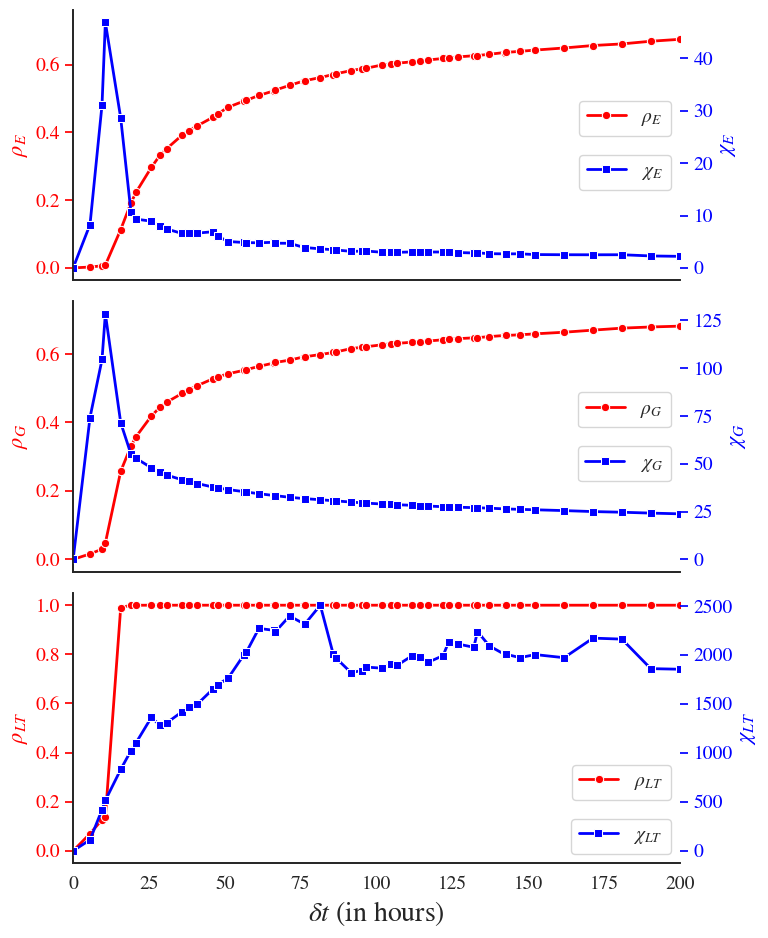

In [11]:
delta_t_values, rho_E, rho_G, rho_LT, chi_E, chi_G, chi_LT, P_S_E_distributions, P_S_LT_distributions, P_S_G_distributions = bipartite_percolation.compute_order_parameters(analysis_results, temporal_graph)


rho_metrics = [rho_E, rho_G, rho_LT]
chi_metrics = [chi_E, chi_G, chi_LT]
labels = [(r'$\rho_E$', r'$\chi_E$'), (r'$\rho_G$', r'$\chi_G$'), (r'$\rho_{LT}$', r'$\chi_{LT}$')]

colors = ('red', 'blue')
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "axes.titlesize": 20,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral"
})

bipartite_percolation.plot_percolation_metrics(delta_t_values, rho_metrics, chi_metrics,labels, colors, time_range=200)


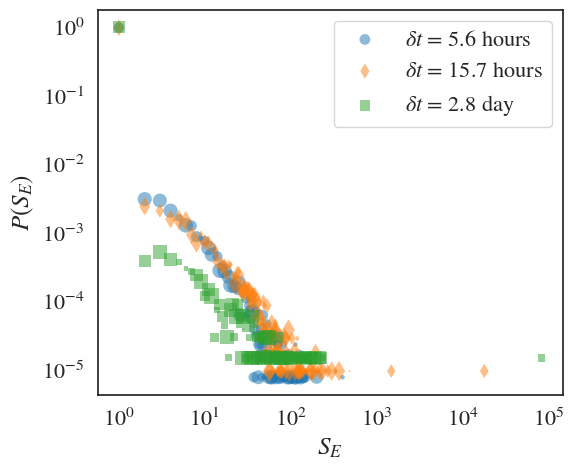

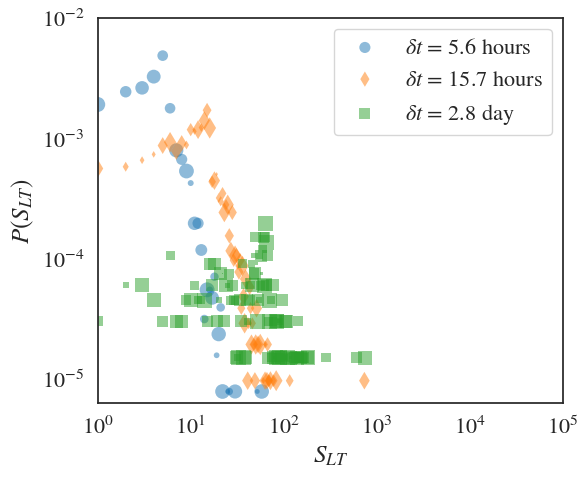

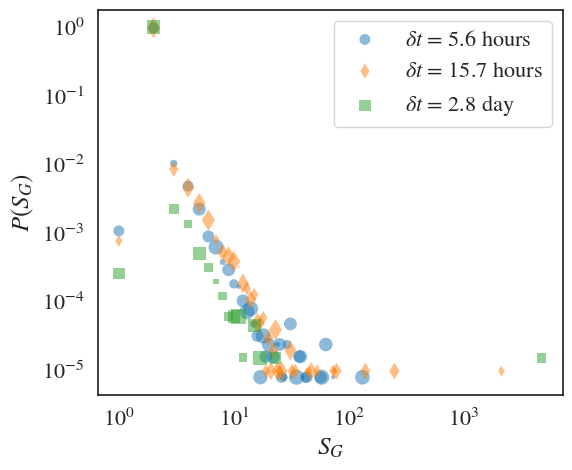

In [ ]:
selected_delta_t_values = [5.555555555555555, 15.671264367816091,66.60210317460317]

color_cycle = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green'])
marker_cycle = itertools.cycle(['o', 'd', 's'])

colors = {dt: next(color_cycle) for dt in selected_delta_t_values}
markers = {dt: next(marker_cycle) for dt in selected_delta_t_values}

# P(S_E)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_E_distributions:
        sizes = np.array(list(P_S_E_distributions[dt].keys()))
        probabilities = np.array(list(P_S_E_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes)) 

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$S_E$")
ax.set_ylabel("$P(S_E)$")
ax.legend()
plt.show()

# P(S_G)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_G_distributions:
        sizes = np.array(list(P_S_G_distributions[dt].keys()))
        probabilities = np.array(list(P_S_G_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes))

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$S_{G}$")
ax.set_ylabel("$P(S_{G})$")
ax.legend(loc="upper right")
plt.show()

# P(S_LT)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_LT_distributions:
        sizes = np.array(list(P_S_LT_distributions[dt].keys()))
        probabilities = np.array(list(P_S_LT_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes))

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**0, 10**5)  

ax.set_ylim(10**-5.2, 10**-2) 
ax.set_xlabel("$S_{LT}$")
ax.set_ylabel("$P(S_{LT})$")
ax.legend(loc="upper right")
plt.show()